In [14]:
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model

# Step 1: Unzip the dataset
zip_path = "/content/archive.zip"  # Change this if your file path is different
extract_path = "/content/extracted1_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 2: Define paths for CSV and image directories
train_csv_path = os.path.join(extract_path, "Train.csv")
test_csv_path = os.path.join(extract_path, "Test.csv")
train_image_dir = os.path.join(extract_path, "Train")
test_image_dir = os.path.join(extract_path, "Test")

# Image size
IMG_SIZE = (128, 128)



In [4]:
import os

# Directory where files are extracted
extract_path = "/content/extracted1_data"

# List the contents
for root, dirs, files in os.walk(extract_path):
    print(f"Directory: {root}")
    for file in files:
        print(f"  - {file}")


Directory: /content/extracted1_data
Directory: /content/extracted1_data/CSV files
Directory: /content/extracted1_data/CSV files/Train
  - Copy of personA_SigVerificationTrainLabels.csv
  - Copy of personE_SigVerificationTrainLabels.csv
  - Copy of personD_SigVerificationTrainLabels.csv
  - Copy of personB_SigVerificationTrainLabels.csv
  - Copy of personC_SigVerificationTrainLabels.csv
Directory: /content/extracted1_data/CSV files/Test
  - Copy of personD_SigVerificationTestLabels.csv
  - Copy of personC_SigVerificationTestLabels.csv
  - Copy of personE_SigVerificationTestLabels.csv
  - Copy of personB_SigVerificationTestLabels.csv
  - Copy of personA_SigVerificationTestLabels.csv
Directory: /content/extracted1_data/Train
Directory: /content/extracted1_data/Train/PersonB
  - Copy of personB_46.png
  - Copy of personB_38.png
  - Copy of personB_31.png
  - Copy of personB_34.png
  - Copy of personB_43.png
  - Copy of personB_26.png
  - Copy of personB_39.png
  - Copy of personB_41.png
  

In [5]:
train_csv_path = "/content/extracted1_data/CSV_Files/Train.csv"  # Adjust based on the output above
test_csv_path = "/content/extracted1_data/CSV_Files/Test.csv"


In [8]:
print(os.path.isfile(train_csv_path))  # Should return True
print(os.path.isfile(test_csv_path))   # Should return True


False
False


In [9]:
import os

# Path where the ZIP file was extracted
extract_path = "/content/extracted1_data"

# List all files and directories in the extracted folder
for root, dirs, files in os.walk(extract_path):
    print(f"Directory: {root}")
    for file in files:
        print(f"  - {file}")


Directory: /content/extracted1_data
Directory: /content/extracted1_data/CSV files
Directory: /content/extracted1_data/CSV files/Train
  - Copy of personA_SigVerificationTrainLabels.csv
  - Copy of personE_SigVerificationTrainLabels.csv
  - Copy of personD_SigVerificationTrainLabels.csv
  - Copy of personB_SigVerificationTrainLabels.csv
  - Copy of personC_SigVerificationTrainLabels.csv
Directory: /content/extracted1_data/CSV files/Test
  - Copy of personD_SigVerificationTestLabels.csv
  - Copy of personC_SigVerificationTestLabels.csv
  - Copy of personE_SigVerificationTestLabels.csv
  - Copy of personB_SigVerificationTestLabels.csv
  - Copy of personA_SigVerificationTestLabels.csv
Directory: /content/extracted1_data/Train
Directory: /content/extracted1_data/Train/PersonB
  - Copy of personB_46.png
  - Copy of personB_38.png
  - Copy of personB_31.png
  - Copy of personB_34.png
  - Copy of personB_43.png
  - Copy of personB_26.png
  - Copy of personB_39.png
  - Copy of personB_41.png
  

In [10]:
train_csv_path = "/content/extracted1_data/Train.csv"  # Update based on actual file location
test_csv_path = "/content/extracted1_data/Test.csv"


In [11]:
print("Train CSV exists:", os.path.isfile(train_csv_path))
print("Test CSV exists:", os.path.isfile(test_csv_path))


Train CSV exists: False
Test CSV exists: False


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [5]:
def load_images_from_folder(folder_path):
    images = []
    labels = []

    for person_dir in os.listdir(folder_path):
        person_path = os.path.join(folder_path, person_dir)
        if not os.path.isdir(person_path):
            continue

        person_images = []
        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (128, 128))
            person_images.append(image)

        # Create pairs: Genuine pairs (same person), Forged pairs (different person)
        num_images = len(person_images)
        for i in range(num_images):
            for j in range(i + 1, num_images):
                images.append([person_images[i], person_images[j]])
                labels.append(1)  # Genuine

        # Forged pairs: Choose randomly from different persons
        for i in range(num_images):
            for other_person_dir in os.listdir(folder_path):
                if other_person_dir == person_dir:
                    continue
                other_person_path = os.path.join(folder_path, other_person_dir)
                other_images = os.listdir(other_person_path)
                other_image_path = os.path.join(other_person_path, other_images[0])
                other_image = cv2.imread(other_image_path, cv2.IMREAD_GRAYSCALE)
                other_image = cv2.resize(other_image, (128, 128))

                images.append([person_images[i], other_image])
                labels.append(0)  # Forged

    return np.array(images), np.array(labels)

# Load training and testing data
train_image_dir = "/content/extracted1_data/Train"
print("Loading training data...")
train_pairs, train_labels = load_images_from_folder(train_image_dir)

# Normalize and expand dimensions
train_pairs = train_pairs / 255.0
train_pairs = np.expand_dims(train_pairs, axis=-1)

print("Training data loaded:", train_pairs.shape)


Loading training data...
Training data loaded: (4700, 2, 128, 128, 1)


In [6]:
def build_siamese_network(input_shape):
    input = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), activation='relu')(input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (5, 5), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    output = layers.Dense(128)(x)

    model = Model(inputs=input, outputs=output)
    return model

def euclidean_distance(vectors):
    x, y = vectors
    return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True))

def build_siamese_model(input_shape):
    base_network = build_siamese_network(input_shape)

    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])
    output = layers.Dense(1, activation="sigmoid")(distance)

    model = Model([input_a, input_b], output)
    return model


In [7]:
input_shape = (128, 128, 1)
siamese_model = build_siamese_model(input_shape)

siamese_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_pairs, train_labels, test_size=0.2, random_state=42)

# Train the model
history = siamese_model.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.5314 - loss: 0.6926 - val_accuracy: 0.6851 - val_loss: 0.6383
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.8535 - loss: 0.6166 - val_accuracy: 0.9447 - val_loss: 0.5759
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.9492 - loss: 0.5577 - val_accuracy: 0.9649 - val_loss: 0.5195
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9672 - loss: 0.5102 - val_accuracy: 0.9979 - val_loss: 0.4750
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.9956 - loss: 0.4595 - val_accuracy: 0.9989 - val_loss: 0.4342
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9993 - loss: 0.4217 - val_accuracy: 1.0000 - val_loss: 0.3876
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9995 - loss: 0.3792 - val_accuracy: 1.0000 - val_loss: 0.3567
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 1.0000 - loss: 0

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.2845
Validation Accuracy: 1.00


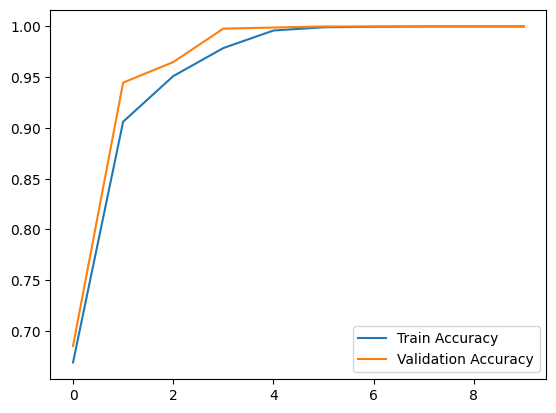

In [8]:
# Evaluate on validation data
val_loss, val_acc = siamese_model.evaluate([X_val[:, 0], X_val[:, 1]], y_val)
print(f"Validation Accuracy: {val_acc:.2f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [10]:
# Load the test dataset
test_image_dir = "/content/extracted1_data/Test"
print("Loading test data...")
test_pairs, test_labels = load_images_from_folder(test_image_dir)

# Normalize and expand dimensions (same preprocessing as for training)
test_pairs = test_pairs / 255.0
test_pairs = np.expand_dims(test_pairs, axis=-1)

print("Test data loaded:", test_pairs.shape)

# Evaluate the model on the test dataset
test_loss, test_acc = siamese_model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f"Test Accuracy: {test_acc:.2f}")

# Optionally, make predictions on the test data
test_predictions = siamese_model.predict([test_pairs[:, 0], test_pairs[:, 1]])

# Optionally, you can visualize a few test predictions
import matplotlib.pyplot as plt
import numpy as np



Loading test data...
Test data loaded: (300, 2, 128, 128, 1)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8603 - loss: 0.3467
Test Accuracy: 0.88
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


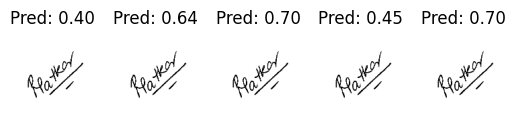

In [11]:
# Optionally, you can visualize a few test predictions
import matplotlib.pyplot as plt
import numpy as np

# Plot some test images along with predicted labels
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_pairs[i, 0].reshape(128, 128), cmap='gray')
    plt.title(f"Pred: {test_predictions[i][0]:.2f}")  # Access the scalar value
    plt.axis('off')
plt.show()


In [12]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import os

# Function to take user input for model parameters
def get_user_input():
    print("Enter the paths to two images for comparison:")
    image_path_a = input("Enter the path of the first image: ")
    image_path_b = input("Enter the path of the second image: ")
    return image_path_a, image_path_b

# Function to preprocess images (resize, normalize, expand dimensions)
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))  # Resize to 128x128
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=-1)  # Add the channel dimension (grayscale -> (128, 128, 1))
    return image

# Build the base network (same as previous code)
def build_siamese_network(input_shape, num_conv_layers, filter_sizes, num_dense_layers, dense_units):
    input = layers.Input(shape=input_shape)
    x = input

    # Add convolutional layers based on user input
    for i in range(num_conv_layers):
        x = layers.Conv2D(64 * (2 ** i), (filter_sizes[i], filter_sizes[i]), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    # Add dense layers based on user input
    for units in dense_units:
        x = layers.Dense(units, activation='relu')(x)

    output = layers.Dense(128)(x)
    model = Model(inputs=input, outputs=output)
    return model

# Function to calculate Euclidean distance
def euclidean_distance(vectors):
    x, y = vectors
    return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True))

# Build the complete Siamese model
def build_siamese_model(input_shape, num_conv_layers, filter_sizes, num_dense_layers, dense_units):
    base_network = build_siamese_network(input_shape, num_conv_layers, filter_sizes, num_dense_layers, dense_units)

    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])
    output = layers.Dense(1, activation="sigmoid")(distance)

    model = Model([input_a, input_b], output)
    return model

# Get user input for images
image_path_a, image_path_b = get_user_input()

# Preprocess the images
image_a = preprocess_image(image_path_a)
image_b = preprocess_image(image_path_b)

# Load the trained model (assuming you've already trained the model)
# For this, you should load the saved model if it's pre-trained or have it ready
# Example:
# siamese_model = tf.keras.models.load_model('path_to_trained_model')

# For the sake of demonstration, assume siamese_model is the trained model already
siamese_model = build_siamese_model((128, 128, 1), 2, [3, 5], 2, [128, 64])
siamese_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Predict similarity between the two images
prediction = siamese_model.predict([np.expand_dims(image_a, axis=0), np.expand_dims(image_b, axis=0)])

# Print the prediction
print(f"Prediction (Similarity Score): {prediction[0][0]:.4f}")
if prediction[0][0] > 0.5:
    print("The images are from the same person (Genuine).")
else:
    print("The images are from different persons (Forged).")


Enter the paths to two images for comparison:
Enter the path of the first image: /content/Real.jpg
Enter the path of the second image: /content/Fake.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction (Similarity Score): 0.5098
The images are from the same person (Genuine).


In [13]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import os

# Function to take user input for model parameters
def get_user_input():
    print("Enter the paths to two images for comparison:")
    image_path_a = input("Enter the path of the first image: ")
    image_path_b = input("Enter the path of the second image: ")
    return image_path_a, image_path_b

# Function to preprocess images (resize, normalize, expand dimensions)
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))  # Resize to 128x128
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=-1)  # Add the channel dimension (grayscale -> (128, 128, 1))
    return image

# Build the base network (same as previous code)
def build_siamese_network(input_shape, num_conv_layers, filter_sizes, num_dense_layers, dense_units):
    input = layers.Input(shape=input_shape)
    x = input

    # Add convolutional layers based on user input
    for i in range(num_conv_layers):
        x = layers.Conv2D(64 * (2 ** i), (filter_sizes[i], filter_sizes[i]), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    # Add dense layers based on user input
    for units in dense_units:
        x = layers.Dense(units, activation='relu')(x)

    output = layers.Dense(128)(x)
    model = Model(inputs=input, outputs=output)
    return model

# Function to calculate Euclidean distance
def euclidean_distance(vectors):
    x, y = vectors
    return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True))

# Build the complete Siamese model
def build_siamese_model(input_shape, num_conv_layers, filter_sizes, num_dense_layers, dense_units):
    base_network = build_siamese_network(input_shape, num_conv_layers, filter_sizes, num_dense_layers, dense_units)

    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])
    output = layers.Dense(1, activation="sigmoid")(distance)

    model = Model([input_a, input_b], output)
    return model

# Get user input for images
image_path_a, image_path_b = get_user_input()

# Preprocess the images
image_a = preprocess_image(image_path_a)
image_b = preprocess_image(image_path_b)

# Load the trained model (assuming you've already trained the model)
# For this, you should load the saved model if it's pre-trained or have it ready
# Example:
# siamese_model = tf.keras.models.load_model('path_to_trained_model')

# For the sake of demonstration, assume siamese_model is the trained model already
siamese_model = build_siamese_model((128, 128, 1), 2, [3, 5], 2, [128, 64])
siamese_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Predict similarity between the two images
prediction = siamese_model.predict([np.expand_dims(image_a, axis=0), np.expand_dims(image_b, axis=0)])

# Print the prediction
print(f"Prediction (Similarity Score): {prediction[0][0]:.4f}")
if prediction[0][0] > 0.5:
    print("The images are from the same person (Genuine).")
else:
    print("The images are from different persons (Forged).")


Enter the paths to two images for comparison:
Enter the path of the first image: /content/Nidhi1.jpg
Enter the path of the second image: /content/Nidhi2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
Prediction (Similarity Score): 0.4864
The images are from different persons (Forged).


In [15]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import os

# Function to take user input for model parameters
def get_user_input():
    print("Enter the paths to two images for comparison:")
    image_path_a = input("Enter the path of the first image: ")
    image_path_b = input("Enter the path of the second image: ")
    return image_path_a, image_path_b

# Function to preprocess images (resize, normalize, expand dimensions)
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))  # Resize to 128x128
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=-1)  # Add the channel dimension (grayscale -> (128, 128, 1))
    return image

# Build the base network (same as previous code)
def build_siamese_network(input_shape, num_conv_layers, filter_sizes, num_dense_layers, dense_units):
    input = layers.Input(shape=input_shape)
    x = input

    # Add convolutional layers based on user input
    for i in range(num_conv_layers):
        x = layers.Conv2D(64 * (2 ** i), (filter_sizes[i], filter_sizes[i]), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    # Add dense layers based on user input
    for units in dense_units:
        x = layers.Dense(units, activation='relu')(x)

    output = layers.Dense(128)(x)
    model = Model(inputs=input, outputs=output)
    return model

# Function to calculate Euclidean distance
def euclidean_distance(vectors):
    x, y = vectors
    return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True))

# Build the complete Siamese model
def build_siamese_model(input_shape, num_conv_layers, filter_sizes, num_dense_layers, dense_units):
    base_network = build_siamese_network(input_shape, num_conv_layers, filter_sizes, num_dense_layers, dense_units)

    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])
    output = layers.Dense(1, activation="sigmoid")(distance)

    model = Model([input_a, input_b], output)
    return model

# Get user input for images
image_path_a, image_path_b = get_user_input()

# Preprocess the images
image_a = preprocess_image(image_path_a)
image_b = preprocess_image(image_path_b)

# Load the trained model (assuming you've already trained the model)
# For this, you should load the saved model if it's pre-trained or have it ready
# Example:
# siamese_model = tf.keras.models.load_model('path_to_trained_model')

# For the sake of demonstration, assume siamese_model is the trained model already
siamese_model = build_siamese_model((128, 128, 1), 2, [3, 5], 2, [128, 64])
siamese_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Predict similarity between the two images
prediction = siamese_model.predict([np.expand_dims(image_a, axis=0), np.expand_dims(image_b, axis=0)])

# Print the prediction
print(f"Prediction (Similarity Score): {prediction[0][0]:.4f}")
if prediction[0][0] > 0.5:
    print("The images are from the same person (Genuine).")
else:
    print("The images are from different persons (Forged).")


Enter the paths to two images for comparison:
Enter the path of the first image: /content/Nidhi2.jpg
Enter the path of the second image: /content/nidhi3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Prediction (Similarity Score): 0.4589
The images are from different persons (Forged).
